In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Proyecto 1 - Autoencoders
## Deep Learning

### Carlos Emiliano Rodríguez Núñez

#### CelebA VAE
* Objetivos:
Comprender los principios fundamentales de los autoencoders y su aplicación en deep learning generativo.
Implementar un autoencoder básico y variacionales para una tarea específica, como reducción de dimensión, denoising o generación de imágenes.
Analizar el rendimiento y las características de las representaciones aprendidas por los autoencoders.


* Descripción
Deberán seleccionar un conjunto de datos adecuado para su proyecto, que puede ser de imágenes, texto o cualquier otro tipo que permita la aplicación de autoencoders.
Implementar un autoencoder, como un variacional (VAE) o un autoencoder convolucional, dependiendo de la naturaleza del conjunto de datos y el objetivo del proyecto.
El proyecto incluirá una fase de experimentación donde los deberán entrenar, ajustar y evaluar sus modelos.
Presentar sus resultados a través de un informe escrito y una presentación, discutir la implementación, los desafíos encontrados, el rendimiento de sus modelos y las aplicaciones potenciales de su trabajo.


* Rúbrica del Proyecto
La rúbrica está dividida en varias categorías, cada una con su propio conjunto de criterios y una escala de puntuación. La puntuación máxima posible es de 100 puntos.

1. Documentación y Presentación (20 puntos)
2. Diseño e Implementación (40 puntos)
3. Experimentación y Análisis (30 puntos)
4. Innovación y Creatividad (10 puntos)

In [3]:
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
from tensorflow.keras import backend as K
import numpy as np
import zipfile
import os
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

Primero importamos librerías y determinamos el tamaño del espacio latente, del batch y las épocas.

In [4]:
batch_size = 100 # hacemos de 100 en 100
latent_dim = 64 # dimensión espacio latente
epochs = 5

Si se utiliza google colab, se elimina lo que se tenga en la carpeta content

In [5]:
!rm -rf /content/extracted_files

Utilizamos un dataset llamado CelebA de pytorch, el cuál contiene miles de imágenes de celebridades de todos los tiempos. Estas imágenes no están centradas ni orientadas, por lo que puede dificultar un poco el entrenamiento de un modelo `VAutoEncoder`.

In [6]:
# Ruta al archivo ZIP que deseas descomprimir
zip_file_path = "/content/drive/MyDrive/ITESO/APRENDIZAJE_PROFUNDO/proyecto_VAE/celebA.zip" # "/content/Archive.zip" "   /content/Archive_2.zip"

# Directorio de destino donde se extraerán los archivos
extract_to_directory = "/content/extracted_files"

# Crear el directorio de destino si no existe
os.makedirs(extract_to_directory, exist_ok=True)

# Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

# Eliminar la carpeta __MACOSX
macosx_folder = os.path.join(extract_to_directory, '__MACOSX')
if os.path.exists(macosx_folder):
    shutil.rmtree(macosx_folder)
    print("Carpeta __MACOSX eliminada con éxito.")

print("¡Archivo ZIP descomprimido y carpeta __MACOSX eliminada con éxito!")


Carpeta __MACOSX eliminada con éxito.
¡Archivo ZIP descomprimido y carpeta __MACOSX eliminada con éxito!


Creamos una función para cargar las imágenes en pixeles de `64x64`

In [7]:
# Función para cargar las imágenes
def load_images_from_folder(folder, target_size=(64, 64)): #------------------------------------------------------------------------------- size en vez de 32
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            # Redimensionar la imagen
            img = img.resize(target_size)
            # Convertir a formato RGB y asegurarse de que tenga solo 3 canales
            img = img.convert('RGB')
            images.append(np.array(img))
            labels.append(0 if random.random() < 0.8 else 1)
    return images, labels

# Directorio donde están tus imágenes
root_directory = '/content/extracted_files/celebA'

# Cargar las imágenes y las etiquetas
images, labels = load_images_from_folder(root_directory)

# Dividir las imágenes y las etiquetas en conjuntos de entrenamiento y prueba
x_train = []
y_train = []
x_test = []
y_test = []

for img, label in zip(images, labels):
    if label == 0:
        x_train.append(img)
        y_train.append(label)
    else:
        x_test.append(img)
        y_test.append(label)

# Convertir listas a numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Imprimir las dimensiones de los conjuntos de entrenamiento y prueba
print('Dimensiones de x_train:', x_train.shape)
print('Dimensiones de y_train:', y_train.shape)
print('Dimensiones de x_test:', x_test.shape)
print('Dimensiones de y_test:', y_test.shape)

Dimensiones de x_train: (23930, 64, 64, 3)
Dimensiones de y_train: (23930,)
Dimensiones de x_test: (6070, 64, 64, 3)
Dimensiones de y_test: (6070,)


Observamos que se tienen aproximadamente `+ 30 mil imágenes`, de las cuales se utilizarán 24 mil para el entrenamiento.
Los AE tienen una entrada `x -> x` y salida x, pero es una práctica interesante separar en train y test. No se utilizará la parte 'y_'

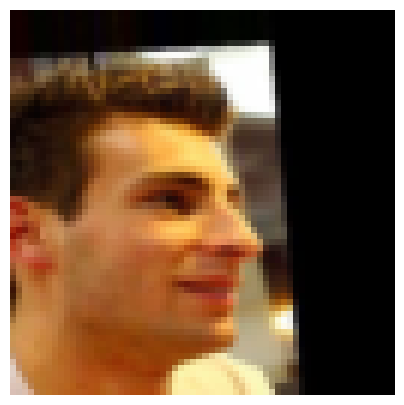

In [8]:
# Convertir el lote de imágenes a un arreglo NumPy
images = x_train

# Seleccionar una imagen aleatoria del lote
index = np.random.randint(len(images))

image = images[0]
# Mostrar la imagen
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()


Imprimimos una imágen aleatoria de 32x32

Realizamos un escalamiento porque los valores van hasta el 255 y para el AutoEncoder se requiere que esté entre `0 y 1` porque son probabilidades.

In [9]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
input_shape = x_train.shape[1:]

In [10]:
input_shape

(64, 64, 3)

Realizamos la función de sampling que utiliza el `promedio` y la `varianza` para generar `el espacio latente`. Creamos el modelo de CONV2D desde 32 hasta 128 con funciones de activación tanh.

In [11]:
def sampling(args):
  z_mean, z_log_var = args

  dim = K.int_shape(z_mean)[1]

  epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim))

  return z_mean + K.exp(0.5 * z_log_var) * epsilon

  # build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, activation = "tanh", strides = 2, padding = "same")(inputs)
x = Conv2D(64, 3, activation = "tanh", strides = 2, padding = "same")(x)
#-----------------------------------------------------------------------
x = Conv2D(128, 3, activation = "tanh", strides = 2, padding = "same")(x)
# x = Conv2D(256, 3, activation = "relu", strides = 2, padding = "same")(x)


# reshape flatten, hay q guardar las salidas de la capa
shape_before_flat = K.int_shape(x)

x = Flatten()(x)
x = Dense(256, activation = "tanh")(x) # flat para encontrar la media y la varianca

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [12]:
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 8, 8, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

Realizamos el decoder con un "efecto espejo" al encoding, solo que poniendo una capa final con función de activación `sigmoide` que de probabilidades de valores entre `0 - 1`, que son las imágenes.

In [13]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

# Check if work
x = Dense(np.prod(shape_before_flat[1:]), activation = "tanh")(latent_inputs)
x = Reshape(shape_before_flat[1:])(x)
#------------------------------------------------------------------------------------------------
# x = Conv2DTranspose(256, 3, activation = "relu", strides = 2, padding = "same")(x) tanh relu
x = Conv2DTranspose(128, 3, activation = "tanh", strides = 2, padding = "same")(x)
#------------------------------------------------------------------------------------------------
x = Conv2DTranspose(64, 3, activation = "tanh", strides = 2, padding = "same")(x)
x = Conv2DTranspose(32, 3, activation = "tanh", strides = 2, padding = "same")(x)

outputs = Conv2DTranspose(3, 3, activation = "sigmoid", padding = "same")(x) # sigmoid
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 8192)              532480    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 64, 64, 32)        1846

In [14]:
outputs

<KerasTensor: shape=(None, 64, 64, 3) dtype=float32 (created by layer 'conv2d_transpose_3')>

In [15]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name = 'vae')


# reconstruction_loss = mean_squared_error(K.flatten(inputs), K.flatten(outputs) * input_shape[0] * input_shape[1])
reconstruction_loss = mean_squared_error(K.flatten(inputs), K.flatten(outputs))

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)


vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 64),                 2223552   ['encoder_input[0][0]']       
                              (None, 64),                                                         
                              (None, 64)]                                                         
                                                                                                  
 decoder (Functional)        (None, 64, 64, 3)            773187    ['encoder[0][2]']             
                                                                                                

Entrenamos.

In [17]:
# Train the autoencoder
vae.fit(x_train,
        epochs=2, # epochs
        batch_size=batch_size,
        validation_data=(x_test, None))


Epoch 1/2
240/240 [==============================] - 387s 2s/step - loss: 0.1000 - val_loss: 0.0923
Epoch 2/2
240/240 [==============================] - 379s 2s/step - loss: 0.0892 - val_loss: 0.0869


Con el siguiente código y usando el x_test, realizamos un encoding para obtener la media y varianza, sacar el espacio latente y después decodeamos para generár la imágen de una celebridad totalmente inventada.

In [18]:
# Obtener z_mean, z_log_var para un lote de imágenes de entrada
z_mean_batch, z_log_var_batch, _ = encoder.predict(x_test)

# Utilizar la función de muestreo para generar muestras de la distribución latente
latent_samples = sampling([z_mean_batch, z_log_var_batch])

# Decodificar las muestras generadas para obtener imágenes "inventadas"
decoded_images = decoder.predict(latent_samples)


190/190 [==============================] - 28s 147ms/step


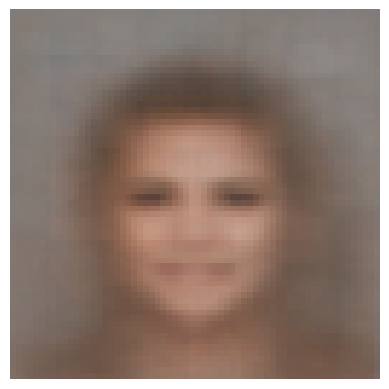

In [19]:
# Elegir una de las imágenes generadas para mostrar
image_to_show = decoded_images[0]

# Mostrar la imagen generada
plt.imshow(image_to_show)
plt.axis('off')
plt.show()


Nmms se ve bien turbio.